# Assignment 3: Clustering

In [1]:
import random, os, sys, shutil
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1: Dataset

### UK Renewable Energy Consumption Dataset

'This dataset details the consumption of energy from 17 different renewable and waste sources from 1990 to 2020. It contains the energy use from each source individually as well as the total consumption. It also contains the total energy consumption from primary fuels and therefore the very useful metric: % of consumption from renewables!'

I will specify later where I have cleaned the dataset so that it is primarily from individual sources.

> https://www.kaggle.com/datasets/magnussesodia/uk-renewable-energy-production

In [2]:
df = pd.read_csv("data/uk_renewable_energy.csv")

In [3]:
#see columns
df.columns

Index(['Year', 'Energy from renewable & waste sources',
       'Total energy consumption of primary fuels and equivalents',
       'Fraction from renewable sources and waste', 'Hydroelectric power',
       'Wind, wave, tidal', 'Solar photovoltaic', 'Geothermal aquifers',
       'Landfill gas', 'Sewage gas', 'Biogas from autogen',
       'Municipal solid waste (MSW)', 'Poultry litter', 'Straw', 'Wood',
       'Charcoal', 'Liquid bio-fuels', 'Bioethanol', 'Biodiesel', 'Biomass',
       'Cross-boundary Adjustment'],
      dtype='object')

In [4]:
#summarise
df.describe()

,Year,Energy from renewable & waste sources,Total energy consumption of primary fuels and equivalents,Fraction from renewable sources and waste,Hydroelectric power,"Wind, wave, tidal",Solar photovoltaic,Geothermal aquifers,Landfill gas,Sewage gas,...,Municipal solid waste (MSW),Poultry litter,Straw,Wood,Charcoal,Liquid bio-fuels,Bioethanol,Biodiesel,Biomass,Cross-boundary Adjustment
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,2005.000000,7.812000,226.586161,0.037516,0.431323,1.299968,0.209581,1.000000e-03,1.023968,0.247387,...,1.118419,0.153613,0.092194,1.844097,0.048226,0.020419,0.169097,0.353065,0.594129,0.005742
std,9.092121,6.833277,20.912081,0.037430,0.067324,1.867693,0.392818,2.204248e-19,0.608756,0.095966,...,0.896538,0.067326,0.098076,1.545942,0.020654,0.047775,0.204388,0.428339,0.695856,0.006552
min,1990.000000,1.634000,169.439000,0.007000,0.278000,0.001000,0.000000,1.000000e-03,0.080000,0.138000,...,0.183000,0.000000,0.007000,0.687000,0.031000,0.000000,0.000000,0.000000,0.029000,0.000000
25%,1997.500000,2.828500,213.876500,0.011500,0.399000,0.065000,0.000000,1.000000e-03,0.359500,0.172000,...,0.549000,0.106500,0.007000,0.772000,0.034500,0.000000,0.000000,0.000000,0.065000,0.000000
50%,2005.000000,5.026000,230.886000,0.020000,0.438000,0.250000,0.001000,1.000000e-03,1.202000,0.193000,...,0.816000,0.176000,0.076000,1.108000,0.038000,0.000000,0.048000,0.027000,0.386000,0.001000
75%,2012.500000,10.380500,244.268500,0.048500,0.463500,2.074500,0.144500,1.000000e-03,1.555000,0.319000,...,1.221000,0.207500,0.098500,2.164500,0.051500,0.015000,0.405000,0.679500,0.665500,0.012500
max,2020.000000,24.472000,252.807000,0.144000,0.580000,6.481000,1.131000,1.000000e-03,1.758000,0.440000,...,3.367000,0.227000,0.338000,5.478000,0.107000,0.202000,0.492000,1.335000,2.469000,0.018000


In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\luoco\AppData\Local\Temp\ipykernel_8336\2001914525.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)
C:\Users\luoco\Miniconda3\envs\STEM\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\luoco\Miniconda3\envs\STEM\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Year,Energy from renewable & waste sources,Total energy consumption of primary fuels and equivalents,Fraction from renewable sources and waste,Hydroelectric power,"Wind, wave, tidal",Solar photovoltaic,Geothermal aquifers,Landfill gas,Sewage gas,Biogas from autogen,Municipal solid waste (MSW),Poultry litter,Straw,Wood,Charcoal,Liquid bio-fuels,Bioethanol,Biodiesel,Biomass,Cross-boundary Adjustment
Year,1.00,0.90,-0.71,0.87,0.50,0.84,0.75,nan,0.86,0.92,0.77,0.89,0.89,0.88,0.81,0.74,0.12,0.88,0.86,0.86,0.86
Energy from renewable & waste sources,0.90,1.00,-0.89,1.00,0.63,0.99,0.95,nan,0.57,0.97,0.96,0.98,0.70,0.97,0.98,0.85,-0.08,0.86,0.87,0.99,0.81
Total energy consumption of primary fuels and equivalents,-0.71,-0.89,1.00,-0.91,-0.70,-0.92,-0.85,nan,-0.37,-0.89,-0.87,-0.83,-0.42,-0.82,-0.90,-0.79,0.23,-0.83,-0.84,-0.88,-0.79
Fraction from renewable sources and waste,0.87,1.00,-0.91,1.00,0.65,1.00,0.95,nan,0.51,0.96,0.97,0.98,0.66,0.97,0.98,0.83,-0.11,0.83,0.86,0.99,0.79
Hydroelectric power,0.50,0.63,-0.70,0.65,1.00,0.65,0.61,nan,0.27,0.60,0.61,0.59,0.31,0.55,0.64,0.50,-0.09,0.52,0.53,0.62,0.49
"Wind, wave, tidal",0.84,0.99,-0.92,1.00,0.65,1.00,0.96,nan,0.47,0.95,0.97,0.97,0.62,0.95,0.98,0.86,-0.14,0.83,0.84,0.98,0.77
Solar photovoltaic,0.75,0.95,-0.85,0.95,0.61,0.96,1.00,nan,0.33,0.88,1.00,0.95,0.53,0.94,0.97,0.81,-0.20,0.72,0.71,0.96,0.61
Geothermal aquifers,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Landfill gas,0.86,0.57,-0.37,0.51,0.27,0.47,0.33,nan,1.00,0.63,0.36,0.54,0.83,0.55,0.42,0.45,0.36,0.72,0.66,0.52,0.74
Sewage gas,0.92,0.97,-0.89,0.96,0.60,0.95,0.88,nan,0.63,1.00,0.91,0.94,0.73,0.91,0.95,0.85,-0.09,0.93,0.89,0.94,0.87


In [7]:
#interesting how geothermal shows up as NaN values but still remains 'False' before.

I want to just look at ones that are primary sources of renewable energy production sources. These are 'totals' or 'fractions of' or from elsewhere (i.e. secondary). So I will drop the following:

- Energy from renewable & waste sources. 
- Total energy consumption of primary fuels and equivalents
- Fraction from renewable sources and waste
- Geothermal aquifers (NaN value)
- Cross Boundary Adjustment (I did not know what this was without google!). 

In [8]:
df = df.drop(["Year", "Energy from renewable & waste sources", "Total energy consumption of primary fuels and equivalents", "Fraction from renewable sources and waste", "Geothermal aquifers", "Cross-boundary Adjustment" ], axis = 1)

In [9]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\luoco\AppData\Local\Temp\ipykernel_8336\2001914525.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Hydroelectric power,"Wind, wave, tidal",Solar photovoltaic,Landfill gas,Sewage gas,Biogas from autogen,Municipal solid waste (MSW),Poultry litter,Straw,Wood,Charcoal,Liquid bio-fuels,Bioethanol,Biodiesel,Biomass
Hydroelectric power,1.00,0.65,0.61,0.27,0.60,0.61,0.59,0.31,0.55,0.64,0.50,-0.09,0.52,0.53,0.62
"Wind, wave, tidal",0.65,1.00,0.96,0.47,0.95,0.97,0.97,0.62,0.95,0.98,0.86,-0.14,0.83,0.84,0.98
Solar photovoltaic,0.61,0.96,1.00,0.33,0.88,1.00,0.95,0.53,0.94,0.97,0.81,-0.20,0.72,0.71,0.96
Landfill gas,0.27,0.47,0.33,1.00,0.63,0.36,0.54,0.83,0.55,0.42,0.45,0.36,0.72,0.66,0.52
Sewage gas,0.60,0.95,0.88,0.63,1.00,0.91,0.94,0.73,0.91,0.95,0.85,-0.09,0.93,0.89,0.94
Biogas from autogen,0.61,0.97,1.00,0.36,0.91,1.00,0.96,0.56,0.95,0.98,0.83,-0.19,0.76,0.74,0.97
Municipal solid waste (MSW),0.59,0.97,0.95,0.54,0.94,0.96,1.00,0.72,0.98,0.96,0.79,-0.09,0.79,0.83,0.98
Poultry litter,0.31,0.62,0.53,0.83,0.73,0.56,0.72,1.00,0.70,0.60,0.55,0.08,0.69,0.65,0.64
Straw,0.55,0.95,0.94,0.55,0.91,0.95,0.98,0.70,1.00,0.94,0.75,-0.06,0.76,0.81,0.98
Wood,0.64,0.98,0.97,0.42,0.95,0.98,0.96,0.60,0.94,1.00,0.86,-0.16,0.82,0.79,0.97


In [31]:
df.isna().any()

Hydroelectric power            False
Wind, wave, tidal              False
Solar photovoltaic             False
Landfill gas                   False
Sewage gas                     False
Biogas from autogen            False
Municipal solid waste (MSW)    False
Poultry litter                 False
Straw                          False
Wood                           False
Charcoal                       False
Liquid bio-fuels               False
Bioethanol                     False
Biodiesel                      False
Biomass                        False
cluster                        False
dtype: bool

### 2: Standardise & 2D Plot (PCA)
PCA to reduces the dataset to only 2 dimensions, therefore we can plot on a 2D axis.

In [10]:
x = df
x_scaled = x
x_scaled = StandardScaler().fit_transform(x_scaled)

In [11]:
#Get the reduced dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_scaled)

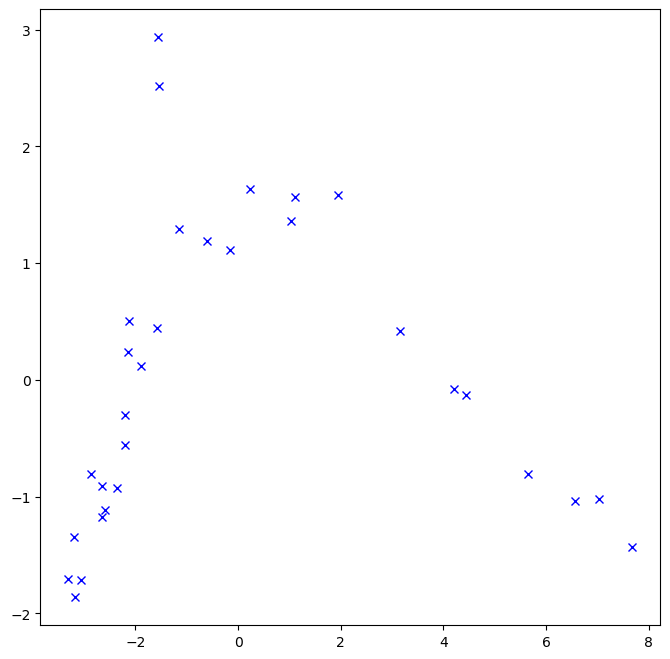

In [12]:
#Plot
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"bx")

### Calculating the BIC scores

This tells us what is potentially the best value for k. It tells us the best model parameters by calculating the Bayesian Information Criteron (BIC score).

In [13]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(x_scaled)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x000002996A3A1E50>)

In [14]:
bic_scores = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
bic_scores["mean_test_score"] = -bic_scores["mean_test_score"]
bic_scores = bic_scores.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
bic_score = bic_scores.sort_values(by="BIC score").head()
print(bic_score)

  Number of components Type of covariance   BIC score
0                    1          spherical  405.507933
1                    2          spherical  491.282708
2                    3          spherical  508.060226
3                    4          spherical  566.252557
4                    5          spherical  729.559223


In [15]:
k = bic_score.iloc[0,0]
cov_type = bic_score.iloc[0,1]

## 3: Visualising the results
### Gaussian Mixture Model (GMM)

In [16]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

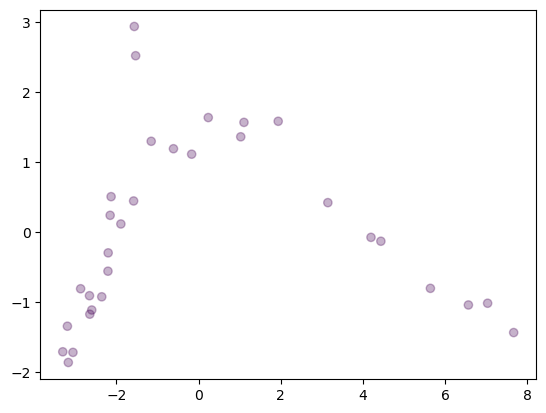

In [17]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

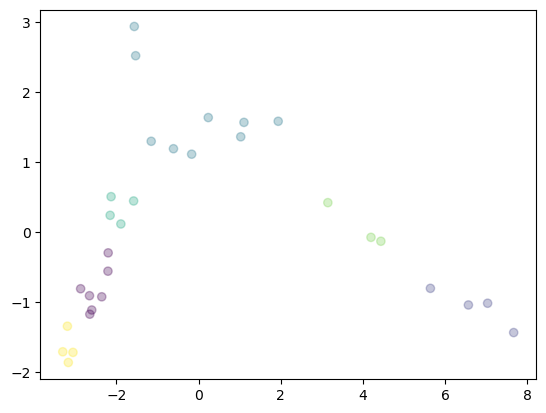

In [18]:
num_dimensions = 2 

#reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

Better results! Even here I think the groupings are quite obvious with the different colours now. 

When in 2 dimensions, this means I can plot the mean and standard deviations around each of our Gaussian probability density functions (PDFs) for each of the clusters.

In [19]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle,  edgecolor='blue', linestyle=':', **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=0.2)
    ax.axis('equal')
    
    w_factor = 0.3 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

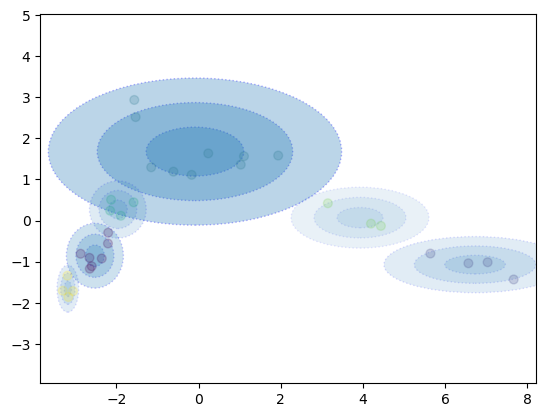

In [20]:
plot_gmm(gmm, x_less_dimensions)

Looking at the clustering of the renewable energy sources above, we can see it has worked out some quite clear cut defined groups. 

Text(0.5, 0, 'cluster number')

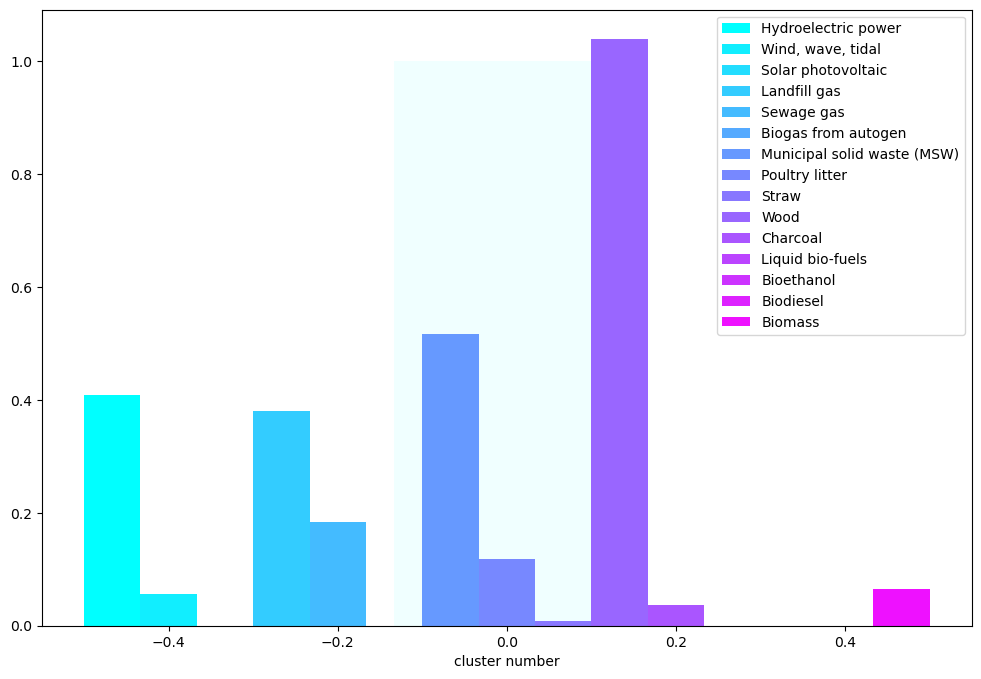

In [32]:
#Add cluster labels as extra column in dataframe
labels = gmm.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Hydroelectric power', 'Wind, wave, tidal', 'Solar photovoltaic', 'Landfill gas', 'Sewage gas', 'Biogas from autogen', 'Municipal solid waste (MSW)', 'Poultry litter', 'Straw', 'Wood', 'Charcoal', 'Liquid bio-fuels', 'Bioethanol', 'Biodiesel', 'Biomass'] 
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

In [25]:
print(x[x['cluster'] == 0])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
4                 0.438              0.030                 0.0         0.188   
5                 0.416              0.034                 0.0         0.199   
6                 0.292              0.042                 0.0         0.249   
7                 0.378              0.057                 0.0         0.317   
8                 0.440              0.075                 0.0         0.402   
9                 0.459              0.073                 0.0         0.572   
10                0.437              0.081                 0.0         0.731   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
4        0.170                  0.0                        0.385   
5        0.193                  0.0                        0.411   
6        0.193                  0.0                        0.396   
7        0.192                  0.0                        0.465   
8        0.181     

In [26]:
print(x[x['cluster'] == 1])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
27                 0.51              4.268               0.985         1.419   
28                 0.47              4.893               1.089         1.298   
29                 0.50              5.485               1.082         1.202   
30                 0.58              6.481               1.131         1.160   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
27       0.398                0.925                        2.561   
28       0.407                0.982                        2.932   
29       0.434                1.016                        3.255   
30       0.440                1.021                        3.367   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
27           0.216  0.261  4.236     0.089             0.001       0.452   
28           0.214  0.259  4.913     0.107             0.000       0.445   
29           0.222  0.335  5.3

In [27]:
print(x[x['cluster'] == 2])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
15                0.423              0.250               0.001         1.421   
16                0.395              0.363               0.001         1.465   
17                0.437              0.453               0.001         1.547   
18                0.442              0.612               0.001         1.554   
19                0.450              0.798               0.002         1.626   
20                0.309              0.884               0.003         1.725   
21                0.489              1.373               0.021         1.758   
22                0.457              1.707               0.116         1.722   
23                0.400              2.442               0.173         1.711   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
15       0.206                0.005                        0.794   
16       0.190                0.006                        0.85

In [28]:
print(x[x['cluster'] == 4])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
24                 0.51              2.748               0.349         1.664   
25                 0.54              3.463               0.648         1.612   
26                 0.46              3.195               0.894         1.556   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
24       0.343                0.367                        1.464   
25       0.366                0.522                        1.952   
26       0.387                0.761                        2.392   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
24           0.208  0.129  3.133     0.082             0.003       0.468   
25           0.222  0.167  4.166     0.080             0.004       0.461   
26           0.227  0.247  4.164     0.053             0.001       0.452   

    Biodiesel  Biomass  cluster  
24      0.785    1.064        4  
25      0.554    1.308        4  

In [29]:
print(x[x['cluster'] == 5])

   Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
0                0.448              0.001                 0.0         0.080   
1                0.398              0.001                 0.0         0.105   
2                0.467              0.003                 0.0         0.155   
3                0.370              0.019                 0.0         0.162   

   Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
0       0.138                  0.0                        0.183   
1       0.151                  0.0                        0.185   
2       0.151                  0.0                        0.210   
3       0.158                  0.0                        0.268   

   Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
0           0.000  0.007  0.687     0.039               0.0         0.0   
1           0.000  0.007  0.687     0.036               0.0         0.0   
2           0.016  0.007  0.736     0.033  

In [30]:
print(x[x['cluster'] == 6])
#therefore 6 clusters total (incl. the 0)

Empty DataFrame
Columns: [Hydroelectric power, Wind, wave, tidal, Solar photovoltaic, Landfill gas, Sewage gas, Biogas from autogen, Municipal solid waste (MSW), Poultry litter, Straw, Wood, Charcoal, Liquid bio-fuels, Bioethanol, Biodiesel, Biomass, cluster]
Index: []


### Findings


I don't think I can truely trust the analysis on the bar chart. Also given that the lightest bar is behind some of the others and that isn't specificied on the legend. I am struggling to see a definitive correlation to the bar chart and the clusters previous. 

From what I can tell, the clusters retain information in some way given the order of the dataset, this is evident from the bar graph colours. It difficult to identify clear groups in the break down of the numbers also in comparison.


Grouped examples:

Hydroelectric power            
Wind, wave, tidal   

Solar photovoltaic             
Landfill gas   

Sewage gas                     
Biogas from autogen  

can be seen well on the chart. Otherwise GMM doesn't appear to be that good of a model for this.

# ------------------------------------------------------------------


# Comparing with k-means clustering

In [53]:
import random, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

AttributeError: module 'matplotlib.pyplot' has no attribute 'x'

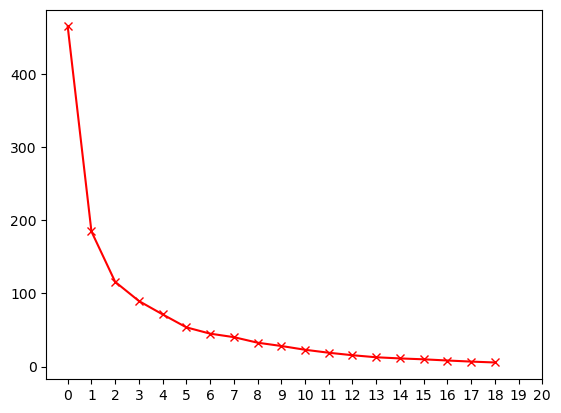

In [55]:
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x_scaled)
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-rx")
plt.xticks(np.arange(0, 21, 1.0))
plt.x

# Plot

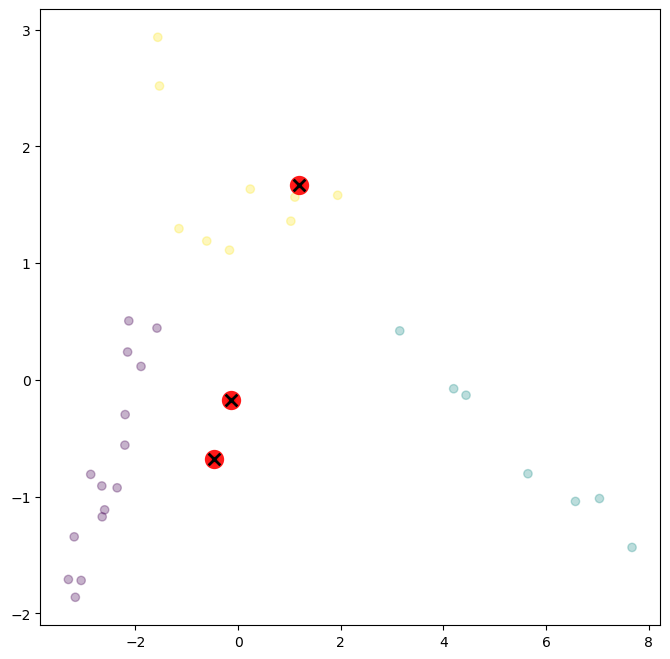

In [60]:
#Let's go with k = 3 (should be the point where there continues to be a linear fall).
#this does identify that the GMM predicted well with 6.
#I will go with 3 to see if there are any differences.

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_scaled)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x_scaled)

This could be interesting how this identifies the 3 groups with the rise and fall of the points in the graph - and the chosen centroids could capture some of the right hand side.

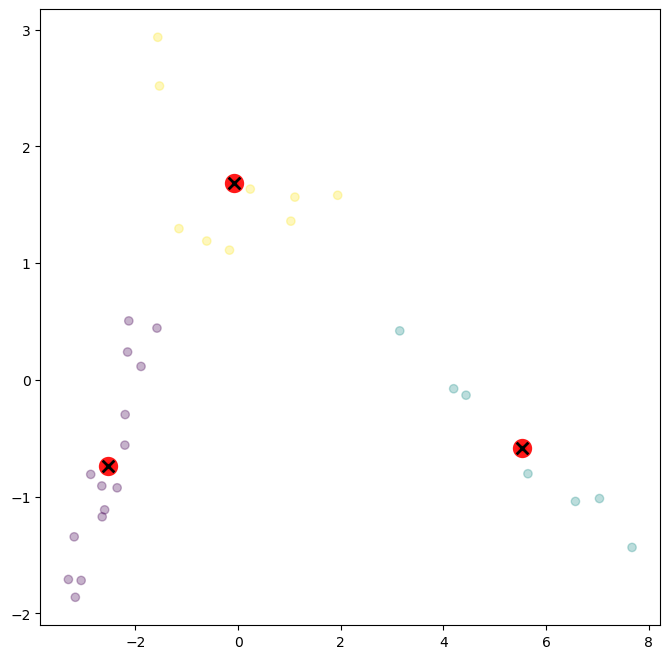

In [64]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

Text(0.5, 0, 'cluster number')

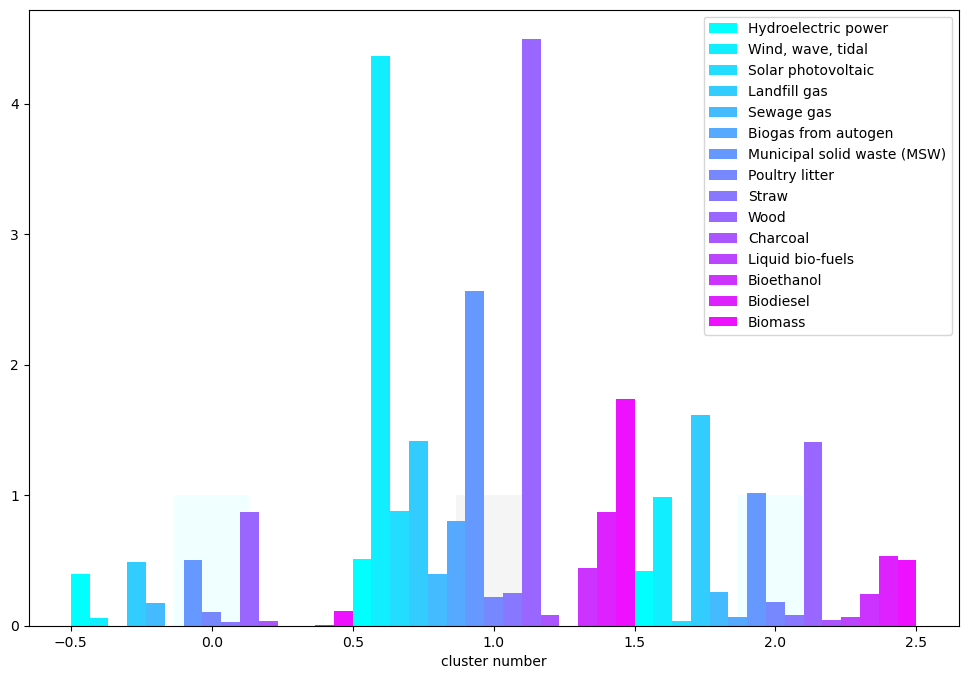

In [66]:
#Add cluster labels as extra column in dataframe
labels = kmeans.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Hydroelectric power', 'Wind, wave, tidal', 'Solar photovoltaic', 'Landfill gas', 'Sewage gas', 'Biogas from autogen', 'Municipal solid waste (MSW)', 'Poultry litter', 'Straw', 'Wood', 'Charcoal', 'Liquid bio-fuels', 'Bioethanol', 'Biodiesel', 'Biomass']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

This one looks a lot more exciting compared to the GMM. I noticed that the GMM didn't capture or plot every single energy source also, as if the value were too close to 0. 

Though I still struggle to see a clear correlation given the height of the bars.

I will check the clusters to see if they are sensible (with a low cluster number like 3, they already seem quite valid with the plot including the centroids.

In [67]:
print(x[x['cluster'] == 0])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
0                 0.448              0.001                 0.0         0.080   
1                 0.398              0.001                 0.0         0.105   
2                 0.467              0.003                 0.0         0.155   
3                 0.370              0.019                 0.0         0.162   
4                 0.438              0.030                 0.0         0.188   
5                 0.416              0.034                 0.0         0.199   
6                 0.292              0.042                 0.0         0.249   
7                 0.378              0.057                 0.0         0.317   
8                 0.440              0.075                 0.0         0.402   
9                 0.459              0.073                 0.0         0.572   
10                0.437              0.081                 0.0         0.731   
11                0.348              0.0

I already notice here that there is a bigger variance in the numbers, making for clear clusters.

For example, some energy sources are close to 0 while others such as hydroelectric power and MSW are far from in comparison.

In [70]:
print(x[x['cluster'] == 1])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
24                 0.51              2.748               0.349         1.664   
25                 0.54              3.463               0.648         1.612   
26                 0.46              3.195               0.894         1.556   
27                 0.51              4.268               0.985         1.419   
28                 0.47              4.893               1.089         1.298   
29                 0.50              5.485               1.082         1.202   
30                 0.58              6.481               1.131         1.160   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
24       0.343                0.367                        1.464   
25       0.366                0.522                        1.952   
26       0.387                0.761                        2.392   
27       0.398                0.925                        2.561   
28       0.407     

In [71]:
print(x[x['cluster'] == 2])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
15                0.423              0.250               0.001         1.421   
16                0.395              0.363               0.001         1.465   
17                0.437              0.453               0.001         1.547   
18                0.442              0.612               0.001         1.554   
19                0.450              0.798               0.002         1.626   
20                0.309              0.884               0.003         1.725   
21                0.489              1.373               0.021         1.758   
22                0.457              1.707               0.116         1.722   
23                0.400              2.442               0.173         1.711   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
15       0.206                0.005                        0.794   
16       0.190                0.006                        0.85

# K-means with different k value

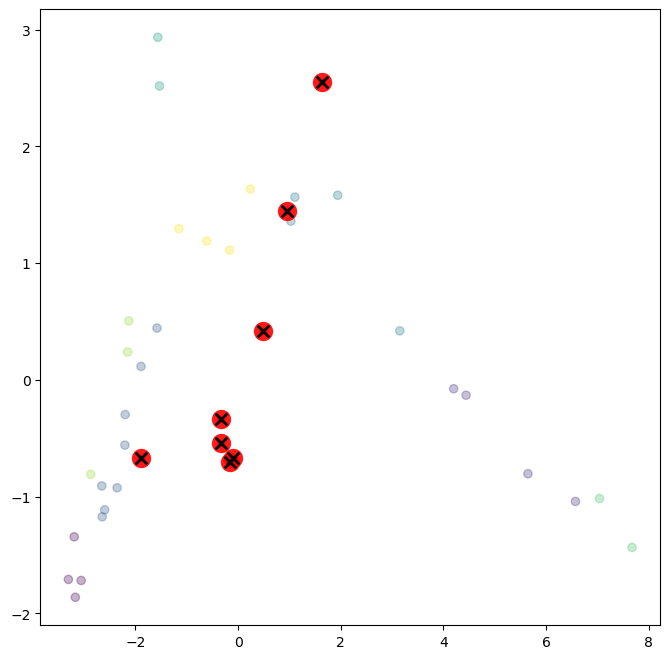

In [75]:
#let's try a much higher value, respectively, and see the results.

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_scaled)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x_scaled)

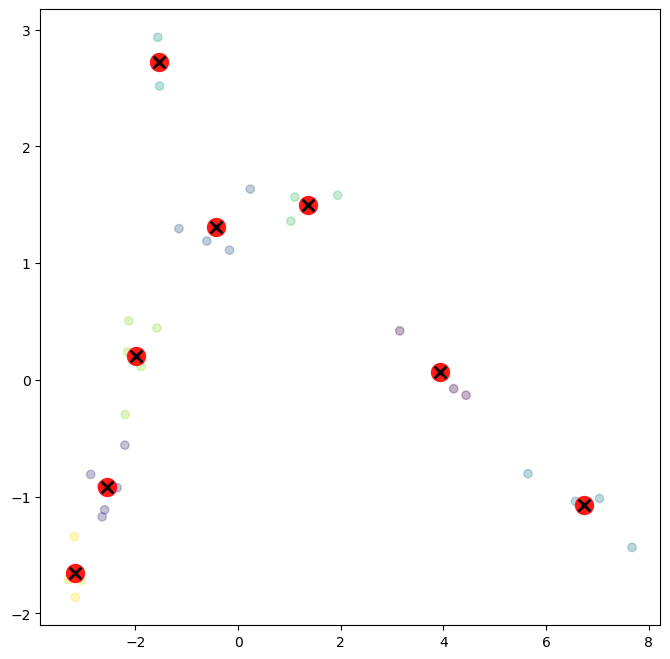

In [76]:
#reduce dimensions
num_dimensions = 2

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

Text(0.5, 0, 'cluster number')

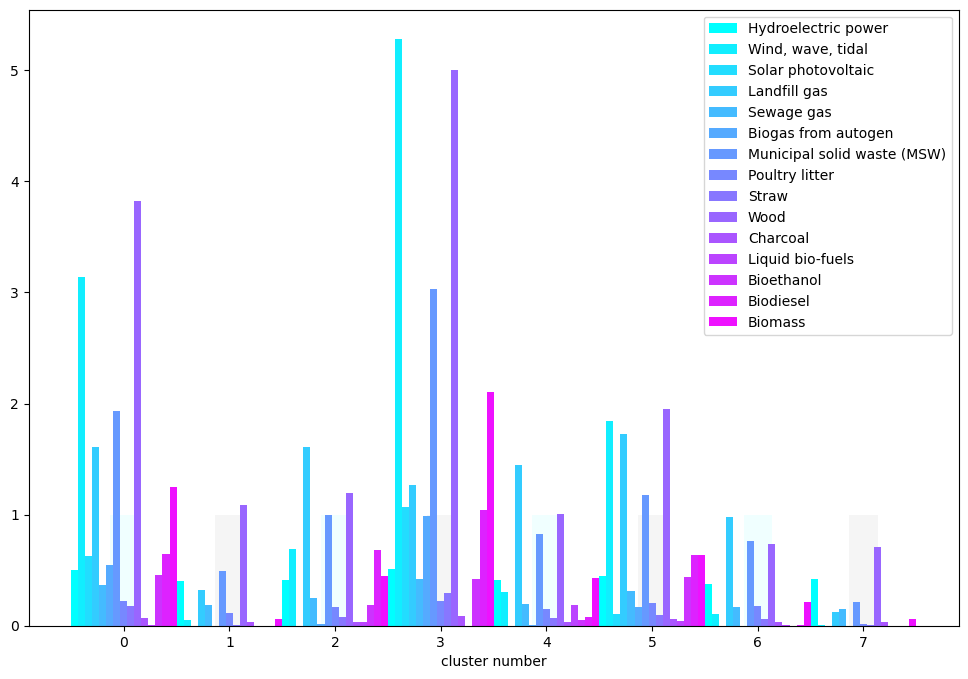

In [77]:
labels = kmeans.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Hydroelectric power', 'Wind, wave, tidal', 'Solar photovoltaic', 'Landfill gas', 'Sewage gas', 'Biogas from autogen', 'Municipal solid waste (MSW)', 'Poultry litter', 'Straw', 'Wood', 'Charcoal', 'Liquid bio-fuels', 'Bioethanol', 'Biodiesel', 'Biomass']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

With the bar repetition, it becomes easier to see some form of correlation between energy sources and which clusters they best fit into with this model.

For example, Hydroelectric Power and Straw both remain high in 2-3 clusters so their energy usage percentage is similar. 

In [78]:
print(x[x['cluster'] == 0])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
24                 0.51              2.748               0.349         1.664   
25                 0.54              3.463               0.648         1.612   
26                 0.46              3.195               0.894         1.556   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
24       0.343                0.367                        1.464   
25       0.366                0.522                        1.952   
26       0.387                0.761                        2.392   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
24           0.208  0.129  3.133     0.082             0.003       0.468   
25           0.222  0.167  4.166     0.080             0.004       0.461   
26           0.227  0.247  4.164     0.053             0.001       0.452   

    Biodiesel  Biomass  cluster  
24      0.785    1.064        0  
25      0.554    1.308        0  

In [79]:
print(x[x['cluster'] == 1])

   Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
4                0.438              0.030                 0.0         0.188   
5                0.416              0.034                 0.0         0.199   
6                0.292              0.042                 0.0         0.249   
7                0.378              0.057                 0.0         0.317   
8                0.440              0.075                 0.0         0.402   
9                0.459              0.073                 0.0         0.572   

   Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
4       0.170                  0.0                        0.385   
5       0.193                  0.0                        0.411   
6       0.193                  0.0                        0.396   
7       0.192                  0.0                        0.465   
8       0.181                  0.0                        0.649   
9       0.189                  0.0          

In [80]:
print(x[x['cluster'] == 2])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
17                0.437              0.453               0.001         1.547   
18                0.442              0.612               0.001         1.554   
19                0.450              0.798               0.002         1.626   
20                0.309              0.884               0.003         1.725   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
17       0.211                0.007                        0.882   
18       0.230                0.009                        0.910   
19       0.249                0.016                        1.089   
20       0.295                0.043                        1.093   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
17           0.152  0.071  0.960     0.034             0.060       0.086   
18           0.179  0.079  1.206     0.031             0.028       0.116   
19           0.176  0.076  1.2

In [81]:
print(x[x['cluster'] == 3])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
27                 0.51              4.268               0.985         1.419   
28                 0.47              4.893               1.089         1.298   
29                 0.50              5.485               1.082         1.202   
30                 0.58              6.481               1.131         1.160   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
27       0.398                0.925                        2.561   
28       0.407                0.982                        2.932   
29       0.434                1.016                        3.255   
30       0.440                1.021                        3.367   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
27           0.216  0.261  4.236     0.089             0.001       0.452   
28           0.214  0.259  4.913     0.107             0.000       0.445   
29           0.222  0.335  5.3

In [82]:
print(x[x['cluster'] == 4])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
15                0.423              0.250               0.001         1.421   
16                0.395              0.363               0.001         1.465   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
15       0.206                0.005                        0.794   
16       0.190                0.006                        0.856   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
15           0.158  0.071  1.019     0.036             0.173       0.048   
16           0.147  0.075  0.992     0.035             0.202       0.054   

    Biodiesel  Biomass  cluster  
15      0.027    0.393        4  
16      0.139    0.458        4  


In [83]:
print(x[x['cluster'] == 5])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
21                0.489              1.373               0.021         1.758   
22                0.457              1.707               0.116         1.722   
23                0.400              2.442               0.173         1.711   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
21       0.318                0.088                        1.087   
22       0.306                0.177                        1.260   
23       0.320                0.252                        1.182   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
21           0.212  0.080  1.537     0.048             0.016       0.367   
22           0.196  0.092  1.811     0.049             0.049       0.463   
23           0.207  0.105  2.518     0.082             0.055       0.492   

    Biodiesel  Biomass  cluster  
21      0.765    0.674        5  
22      0.522    0.586        5  

In [84]:
print(x[x['cluster'] == 6])

    Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
10                0.437              0.081                 0.0         0.731   
11                0.348              0.083                 0.0         0.836   
12                0.412              0.108                 0.0         0.892   
13                0.278              0.111                 0.0         1.088   
14                0.418              0.166                 0.0         1.327   

    Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
10       0.169                0.000                        0.678   
11       0.168                0.000                        0.731   
12       0.174                0.000                        0.795   
13       0.165                0.003                        0.816   
14       0.177                0.005                        0.790   

    Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
10           0.159  0.015  0.766  

In [85]:
print(x[x['cluster'] == 7])

   Hydroelectric power  Wind, wave, tidal  Solar photovoltaic  Landfill gas  \
0                0.448              0.001                 0.0         0.080   
1                0.398              0.001                 0.0         0.105   
2                0.467              0.003                 0.0         0.155   
3                0.370              0.019                 0.0         0.162   

   Sewage gas  Biogas from autogen  Municipal solid waste (MSW)  \
0       0.138                  0.0                        0.183   
1       0.151                  0.0                        0.185   
2       0.151                  0.0                        0.210   
3       0.158                  0.0                        0.268   

   Poultry litter  Straw   Wood  Charcoal  Liquid bio-fuels  Bioethanol  \
0           0.000  0.007  0.687     0.039               0.0         0.0   
1           0.000  0.007  0.687     0.036               0.0         0.0   
2           0.016  0.007  0.736     0.033  

Looking over these numbers, I think the more interesting aspect of this is that because the dataset is renewable energy consumption as percentages over the years given, what this data identifies is that there isn't necessarily a correlation between similar types of renewable energies, yet a better similarity between those which have similar percentage usage statistics.

So the patterns aren't clear until you coinside them against the correlation gradient table. 